In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/salifort-dataset/HR_Sailfort_dataset.csv


**Note**- Building upon the insights of the Salifort Motors employee churn analysis Part 1, this project delves deeper into predictive modeling. After exploring the data and developing a Logistic Regression model in the first part, I will now construct Decision Tree and Random Forest Classifiers. If you haven't explored the first part, I recommend reviewing it for a more comprehensive understanding.

In [2]:
# Import all necessary libraries and packages

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_auc_score, roc_curve

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder

In [3]:
# Load in Salifort dataset
sf= pd.read_csv('/kaggle/input/salifort-dataset/HR_Sailfort_dataset.csv')

In [4]:
# View the dataset
sf.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [5]:
# Check mispellings, rename columns and writing columns in snake_case format
sf= sf.rename(columns={'Work_accident': 'work_accident',
                                   'average_montly_hours': 'average_monthly_hours',
                                   'time_spend_company': 'tenure',
                                   'Department': 'department'})
sf.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_monthly_hours', 'tenure', 'work_accident', 'left',
       'promotion_last_5years', 'department', 'salary'],
      dtype='object')

In [6]:
# Copy the dataframe
sfdf_encode= sf.copy()
sfdf_encode.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [7]:
# Encode 'salary column'
sfdf_encode['salary'] = (sfdf_encode['salary'].astype('category') .cat.set_categories(['low', 'medium', 'high']).cat.codes)

# Encode 'department' column
sfdf_encode= pd.get_dummies(sfdf_encode, drop_first= False)

sfdf_encode.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,salary,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
0,0.38,0.53,2,157,3,0,1,0,0,False,False,False,False,False,False,False,True,False,False
1,0.80,0.86,5,262,6,0,1,0,1,False,False,False,False,False,False,False,True,False,False
2,0.11,0.88,7,272,4,0,1,0,1,False,False,False,False,False,False,False,True,False,False
3,0.72,0.87,5,223,5,0,1,0,0,False,False,False,False,False,False,False,True,False,False
4,0.37,0.52,2,159,3,0,1,0,0,False,False,False,False,False,False,False,True,False,False


In [8]:
# Identify outliers
percentile25 = sfdf_encode['tenure'].quantile(0.25)
percentile75 = sfdf_encode['tenure'].quantile(0.75)
iqr = percentile75 - percentile25
upper_limit = percentile75 + 1.5 * iqr
lower_limit = percentile25 - 1.5 * iqr

# 'tenure' outliers removal
lrsf= sfdf_encode[(sfdf_encode['tenure'] >= lower_limit) & (sfdf_encode['tenure'] <= upper_limit)]
lrsf.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,salary,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
0,0.38,0.53,2,157,3,0,1,0,0,False,False,False,False,False,False,False,True,False,False
2,0.11,0.88,7,272,4,0,1,0,1,False,False,False,False,False,False,False,True,False,False
3,0.72,0.87,5,223,5,0,1,0,0,False,False,False,False,False,False,False,True,False,False
4,0.37,0.52,2,159,3,0,1,0,0,False,False,False,False,False,False,False,True,False,False
5,0.41,0.50,2,153,3,0,1,0,0,False,False,False,False,False,False,False,True,False,False


**Model II- Decision Tree**

My second model is going to be a decision tree classifier, which are intuitive and easy to interpret, making them ideal for gaining insights into the factors driving employee churn. The visual representation of the decision tree important features allows stakeholders to understand the decision-making process and identify the most influential variables affecting churn.  

Decision trees naturally handle feature interactions and nonlinear relationships, enabling the model to capture complex patterns in the data that might contribute to employee churn. Another advantage is that decision trees automatically perform feature selection by identifying the most informative attributes for splitting, which can help in simplifying the model and reducing overfitting. Furthermore, decision trees can handle imbalanced datasets, common in employee churn prediction, by adjusting class weights or using techniques like ensemble learning.

Overall, the interpretability, versatility, and ability to handle complex data make decision tree models a valuable tool for predicting employee churn and informing strategic decision-making.

In [9]:
# Isolate target feature
y= lrsf['left']
y.head()

0    1
2    1
3    1
4    1
5    1
Name: left, dtype: int64

In [10]:
# Features for the model
X= lrsf.drop('left', axis=1)
X.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,promotion_last_5years,salary,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
0,0.38,0.53,2,157,3,0,0,0,False,False,False,False,False,False,False,True,False,False
2,0.11,0.88,7,272,4,0,0,1,False,False,False,False,False,False,False,True,False,False
3,0.72,0.87,5,223,5,0,0,0,False,False,False,False,False,False,False,True,False,False
4,0.37,0.52,2,159,3,0,0,0,False,False,False,False,False,False,False,True,False,False
5,0.41,0.50,2,153,3,0,0,0,False,False,False,False,False,False,False,True,False,False


In [11]:
# Split the data
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size= 0.25, stratify= y, random_state= 42)

In [12]:
# Hyperparameter tuning for decision tree using grid search cross-validation
dt= DecisionTreeClassifier(random_state= 42)

cv_params= {'max_depth': [4,6,8,None],
            'min_samples_leaf': [2,5,1],
            'min_samples_split': [2,4,6]}

scoring= {'accuracy', 'precision', 'recall', 'f1', 'roc_auc'}

tree1= GridSearchCV(dt, cv_params, scoring= scoring, cv= 4, refit= 'roc_auc')

In [13]:
%%time
# Fit decision tree to training data
tree1.fit(X_train, y_train)

CPU times: user 5.74 s, sys: 6.07 ms, total: 5.75 s
Wall time: 5.76 s


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_depth': [4, 6, 8, None],
                         'min_samples_leaf': [2, 5, 1],
                         'min_samples_split': [2, 4, 6]},
             refit='roc_auc',
             scoring={'recall', 'precision', 'roc_auc', 'f1', 'accuracy'})

In [14]:
# Check for best parameters
tree1.best_params_

{'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 2}

In [15]:
# Check best AUC score
tree1.best_score_

0.9821859074404926

**Decision Tree AUC Score**

The AUC (Area Under the ROC Curve) score of 98.2% obtained from the decision tree classifier indicates *exceptional* performance in predicting employee churn. With a score so close to the maximum value of 1, the classifier demonstrates a high level of accuracy in distinguishing between employees who are likely to leave and those who are likely to stay. This means that the model can effectively identify employees at risk of churning, providing valuable insights for proactive intervention and retention strategies. 

Now, I will create a new dataframe with with the F1, recall, precision, accuracy, and auc scores for the model with the best mean 'metric' score across all validation folds. The new dataframe will contain the performance metrics of the model that achieved the highest average score during cross-validation.

In [16]:
# Extract scores from grid search
def results(model_name:str, model_object, metric:str):
    metric_tests= {'auc': 'mean_test_roc_auc',
             'precision': 'mean_test_precision',
             'recall': 'mean_test_recall',
             'F1': 'mean_test_f1',
             'accuracy': 'mean_test_accuracy'}
    
    # Results from CV in new dataframe
    cv_results= pd.DataFrame(model_object.cv_results_)
    
    # Isolate new row of the dataframe with max metric score
    best_estimator_results= cv_results.iloc[cv_results[metric_tests[metric]].idxmax(),:]
    
    # Extract scores from isolated row
    auc= best_estimator_results.mean_test_roc_auc
    f1= best_estimator_results.mean_test_f1
    recall= best_estimator_results.mean_test_recall
    precision= best_estimator_results.mean_test_precision
    accuracy= best_estimator_results.mean_test_accuracy
    
    # Table of results
    table= pd.DataFrame()
    table= pd.DataFrame({'Model': [model_name],
                         'Precision': [precision],
                         'Recall': [recall],
                         'F1': [f1],
                         'Accuracy': [accuracy],
                         'AUC': [auc]
                        })
    return table

In [17]:
# CV scores
tree1_results= results('Decision Tree CV', tree1, 'auc')
tree1_results

,Model,Precision,Recall,F1,Accuracy,AUC
0,Decision Tree CV,0.965476,0.937723,0.95127,0.976475,0.982186


**Decision Tree Results**

* **Precision**- This means that for the employees the model predicts will leave, 96.6% of them actually leave. This is a high value, indicating that the model is good at identifying true churners.

* **Recall**- This means that the model identifies 93.7% of the actual churners. This is also a high value, indicating that the model is not missing many true churners.

* **F1-Score**- The F1-score is a harmonic mean of precision and recall, which provides a balanced measure of both. A score of 95.1% is very good, indicating that the model has a strong balance between precision and recall.

* **Accuracy**- This means that the model correctly predicts whether an employee will leave or not 97.6% of the time. This is an excellent accuracy score.

* **AUC**- The Area Under the ROC Curve (AUC) is a measure of the model's ability to distinguish between positive and negative cases. An AUC of 98.2% is very high, indicating that the model is very good at distinguishing between employees who will and will not leave.

The Decision Tree model appears to be a strong choice for predicting employee churn. It has high precision, recall, F1-score, accuracy, and AUC, indicating that it is both accurate and highly effective at identifying both true positives and true negatives.

**Model III- Random Forest**

Creating a Random Forest machine learning model to predict employee churn offers several advantages. Random Forest is an ensemble learning technique that combines multiple decision trees to improve predictive accuracy and reduce overfitting. This model excels in handling high-dimensional datasets with numerous features, making it suitable for the complex nature of employee churn prediction. Additionally, Random Forest automatically selects the most important features, providing insights into the factors contributing most significantly to employee turnover.

Its ability to capture non-linear relationships and interactions among features enhances prediction performance. Moreover, Random Forest is robust against outliers and noise in the data, contributing to its stability and reliability. By leveraging these strengths, a Random Forest model can effectively identify patterns and predict employee churn, enabling proactive retention strategies and informed decision-making.

In [18]:
# Hyperparameter tuning for random forest using grid search cross-validation
rf= RandomForestClassifier(random_state= 0)

cv_params={'max_depth': [3,5,None],
           'max_features': [1.0],
           'max_samples': [0.7,1.0],
           'min_samples_leaf': [1,2,3],
           'min_samples_split': [2,3,4],
           'n_estimators': [300,500]
          }

scoring= {'accuracy', 'precision', 'recall', 'f1', 'roc_auc'}

rf1= GridSearchCV(rf, cv_params, scoring= scoring, cv= 4, refit= 'roc_auc')

In [19]:
%%time
# Fit random forest to training data
rf1.fit(X_train, y_train)

CPU times: user 34min 33s, sys: 4.42 s, total: 34min 37s
Wall time: 34min 38s


GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [3, 5, None], 'max_features': [1.0],
                         'max_samples': [0.7, 1.0],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [300, 500]},
             refit='roc_auc',
             scoring={'recall', 'precision', 'roc_auc', 'f1', 'accuracy'})

In [20]:
# Check best parameters
rf1.best_params_

{'max_depth': None,
 'max_features': 1.0,
 'max_samples': 0.7,
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'n_estimators': 500}

In [21]:
# Check best AUC score
rf1.best_score_

0.9901213221721747

**Random Forest AUC Score**

The Random Forest model achieved an outstanding AUC score of 99%. This metric signifies an exceptional capability for predicting employee churn. In simpler terms, if we were to select a random employee who left the company and another who remained, the model has a near 99% chance of correctly classifying the employee who departed as having a higher risk of churn. This exceptional performance suggests the model has effectively learned intricate relationships within the data that hold strong correlations with employee turnover tendencies. This high AUC score instills confidence in the model's ability to serve as a valuable tool for identifying employees at risk of leaving. By providing crucial insights, the model can empower proactive retention efforts within the organization.

In [22]:
# CV scores
rf1_results= results('Random Forest CV', rf1, 'auc')
print(tree1_results)
print(rf1_results)

              Model  Precision    Recall       F1  Accuracy       AUC
0  Decision Tree CV   0.965476  0.937723  0.95127  0.976475  0.982186
              Model  Precision    Recall        F1  Accuracy       AUC
0  Random Forest CV   0.984125  0.932959  0.957803  0.979878  0.990121


**Decision Tree vs Random Forest**

The comparison between the Decision Tree and Random Forest models for predicting employee churn reveals distinct performance characteristics. 

Starting with precision, both models exhibit high values, with the Random Forest model slightly outperforming the Decision Tree, showcasing its ability to accurately classify true positives. 

In terms of recall, the Decision Tree also demonstrates strong performance, but the Random Forest's recall score is slightly lower, indicating a slightly higher false negative rate.

Moving to the F1 score, which balances precision and recall, the Random Forest model achieves a higher score, implying better overall predictive capability.

Furthermore, both models showcase high accuracy, with the Random Forest model again edging out the Decision Tree. 

Finally, looking at the Area Under the ROC Curve (AUC), which evaluates the model's ability to discriminate between positive and negative classes, the Random Forest model exhibits a notably higher score, indicating superior performance in distinguishing between churn and non-churn instances.

While both models perform well, the Random Forest model appears to offer slightly better predictive accuracy and robustness, making it a preferable choice for predicting employee churn in this scenario.

**Test Set**

Now, I'm going to evaluate the final model on the test set. Performing this on the test set is a crucial step in the machine learning process, serving multiple purposes. It allows for the assessment of the model's ability to generalize to new, unseen data, ensuring that it can make accurate predictions beyond the training set. This evaluation also helps detect and mitigate overfitting, where the model memorizes the training data but fails to generalize well. By measuring performance metrics such as accuracy, precision, recall, F1-score, and ROC AUC on the test set, stakeholders can gain confidence in the model's reliability and effectiveness.

In [23]:
# All scores from model predictions
def get_scores(model_name:str, model, X_test_data, y_test_data):
    preds= model.best_estimator_.predict(X_test_data)
    
    auc= roc_auc_score(y_test_data, preds)
    accuracy= accuracy_score(y_test_data, preds)
    precision= precision_score(y_test_data, preds)
    recall= recall_score(y_test_data, preds)
    f1= f1_score(y_test_data, preds)
    
    table= pd.DataFrame({'Model': [model_name],
                         'Precision': [precision],
                         'Recall': [recall],
                         'F1': [f1],
                         'Accuracy': [accuracy],
                         'AUC': [auc]
                        })
    return table

In [24]:
# Prediction on test data
rf1_test_scores= get_scores('Random Forest 1 Test', rf1, X_test, y_test)
rf1_test_scores

,Model,Precision,Recall,F1,Accuracy,AUC
0,Random Forest 1 Test,0.991184,0.935791,0.962691,0.982216,0.966543


**Test Scores**

The similarity between the test scores and the validation scores indicates that the model's performance is consistent, which is encouraging. This suggests that the model is robust and generalizes well to new, unseen data. Since the test set was solely used for evaluating this model, I now have greater confidence that its performance on this data is indicative of how it will perform on the unseen data. This alignment between validation and test scores enhances my trust in the model's ability to make accurate predictions.

**Feature Engineering**

Even though I feel very confident about the models so far, there's reason to approach the high evaluation scores with caution as there may be underlying issues like data leakage. Data leakage refers to a situation in machine learning where information from outside the training dataset inadvertently influences the model's training process, leading to overly optimistic performance metrics. 

With the Salifort Motors dataset, it's probable that not all employees' satisfaction levels are recorded, leading to potential data leakage. Additionally, the 'average_monthly_hours' column could be another source of leakage. If employees who are already planning to quit or are targeted for termination by management work fewer hours, it could skew the data. To address these concerns, the upcoming round of decision tree and random forest models will focus on feature engineering to enhance model performance and mitigate the risk of data leakage.

My first decision tree and first random forest models included all the variables as features. Now, I will incorporate feature engineering to build improved models (hopefully).

In [25]:
# Create new dataframe without 'satisfaction_level'
sfdf2= sfdf_encode.drop('satisfaction_level', axis=1)
sfdf2.head()

,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,salary,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
0,0.53,2,157,3,0,1,0,0,False,False,False,False,False,False,False,True,False,False
1,0.86,5,262,6,0,1,0,1,False,False,False,False,False,False,False,True,False,False
2,0.88,7,272,4,0,1,0,1,False,False,False,False,False,False,False,True,False,False
3,0.87,5,223,5,0,1,0,0,False,False,False,False,False,False,False,True,False,False
4,0.52,2,159,3,0,1,0,0,False,False,False,False,False,False,False,True,False,False


In [26]:
# 'overworked' column
sfdf2['overworked']= sfdf2['average_monthly_hours']
print('Max work hours: ', sfdf2['overworked'].max())
print('Min work hours: ', sfdf2['overworked'].min())

Max work hours:  310
Min work hours:  96


In [27]:
# Define overworked as working > 175 hrs
sfdf2['overworked']= (sfdf2['overworked'] > 175).astype(int)
sfdf2['overworked'].head()

0    0
1    1
2    1
3    1
4    0
Name: overworked, dtype: int64

In [28]:
# Drop 'average_monthly_hours' column
sfdf2= sfdf2.drop('average_monthly_hours', axis=1)
sfdf2.head()

,last_evaluation,number_project,tenure,work_accident,left,promotion_last_5years,salary,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical,overworked
0,0.53,2,3,0,1,0,0,False,False,False,False,False,False,False,True,False,False,0
1,0.86,5,6,0,1,0,1,False,False,False,False,False,False,False,True,False,False,1
2,0.88,7,4,0,1,0,1,False,False,False,False,False,False,False,True,False,False,1
3,0.87,5,5,0,1,0,0,False,False,False,False,False,False,False,True,False,False,1
4,0.52,2,3,0,1,0,0,False,False,False,False,False,False,False,True,False,False,0


In [29]:
# Isolate target feature
y= sfdf2['left']

In [30]:
# Select features
X= sfdf2.drop('left', axis=1)

In [31]:
# Split the data
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size= 0.25, stratify= y, random_state= 0)

In [32]:
# Decision Tree 2
dt= DecisionTreeClassifier(random_state= 0)

cv_params= {'max_depth': [4,6,8,None],
            'min_samples_leaf': [2,5,1],
            'min_samples_split': [2,4,6]
           }

scoring= {'accuracy', 'precision', 'recall', 'f1', 'roc_auc'}

tree2= GridSearchCV(dt, cv_params, scoring= scoring, cv= 4, refit= 'roc_auc')

In [33]:
%%time
tree2.fit(X_train, y_train)

CPU times: user 5.02 s, sys: 2.86 ms, total: 5.02 s
Wall time: 5.02 s


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'max_depth': [4, 6, 8, None],
                         'min_samples_leaf': [2, 5, 1],
                         'min_samples_split': [2, 4, 6]},
             refit='roc_auc',
             scoring={'recall', 'precision', 'roc_auc', 'f1', 'accuracy'})

In [34]:
# Check best parameters
tree2.best_params_

{'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 2}

In [35]:
# AUC Score
tree2.best_score_

0.9707127603293837

In [36]:
# All CV scores
tree2_results= results('Decision Tree 2 CV', tree2, 'auc')
print(tree1_results)
print(tree2_results)

              Model  Precision    Recall       F1  Accuracy       AUC
0  Decision Tree CV   0.965476  0.937723  0.95127  0.976475  0.982186
                Model  Precision    Recall        F1  Accuracy       AUC
0  Decision Tree 2 CV    0.91728  0.891332  0.904003   0.95493  0.970713


Even though some of the scores are a bit low, the results are still very promising. Lower scores are to be expected since some of the features were dropped.

In [37]:
# Random Forest 2
rf= RandomForestClassifier(random_state= 0)

cv_params= {'max_depth': [3,5,None],
            'max_features': [1,0],
            'max_samples': [0.7,1.0],
            'min_samples_leaf': [1,2,3],
            'min_samples_split': [2,3,4],
            'n_estimators': [300,500]
           }

scoring= {'accuracy', 'precision', 'recall', 'f1', 'roc_auc'}
rf2= GridSearchCV(rf, cv_params, scoring= scoring, cv= 4, refit= 'roc_auc')

In [38]:
%%time
rf2.fit(X_train, y_train)

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defin

CPU times: user 13min 16s, sys: 3.86 s, total: 13min 20s
Wall time: 13min 21s


GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [3, 5, None], 'max_features': [1, 0],
                         'max_samples': [0.7, 1.0],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [300, 500]},
             refit='roc_auc',
             scoring={'recall', 'precision', 'roc_auc', 'f1', 'accuracy'})

In [39]:
# Best parameters
rf2.best_params_

{'max_depth': None,
 'max_features': 1,
 'max_samples': 1.0,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 500}

In [40]:
# Best AUC Score
rf2.best_score_

0.9804090921454861

In [41]:
# Predictions on test data
rf2_test_scores= get_scores('Random Forest 2 Test',rf2, X_test, y_test)
rf2_test_scores

,Model,Precision,Recall,F1,Accuracy,AUC
0,Random Forest 2 Test,0.932401,0.895857,0.913764,0.959733,0.937778


This final model appears to be stable and performing well.

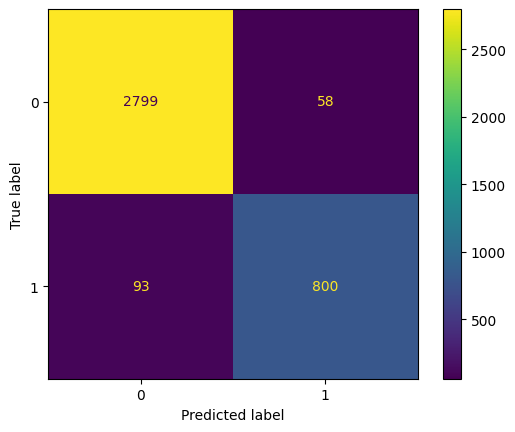

In [42]:
# Confusion matrix
preds= rf2.best_estimator_.predict(X_test)
cm= confusion_matrix(y_test, preds, labels= rf2.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix= cm, display_labels= rf2.classes_)
disp.plot(values_format='')
plt.show()

**Confusion Matrix**

The confusion matrix shows that the model performs reasonably well in predicting both churn and non-churn cases. The high number of True Negatives suggests that the model is effective in identifying employees who are likely to stay with the company. Additionally, the relatively low number of False Positives indicates that the model does not falsely flag too many non-churn cases as churn.

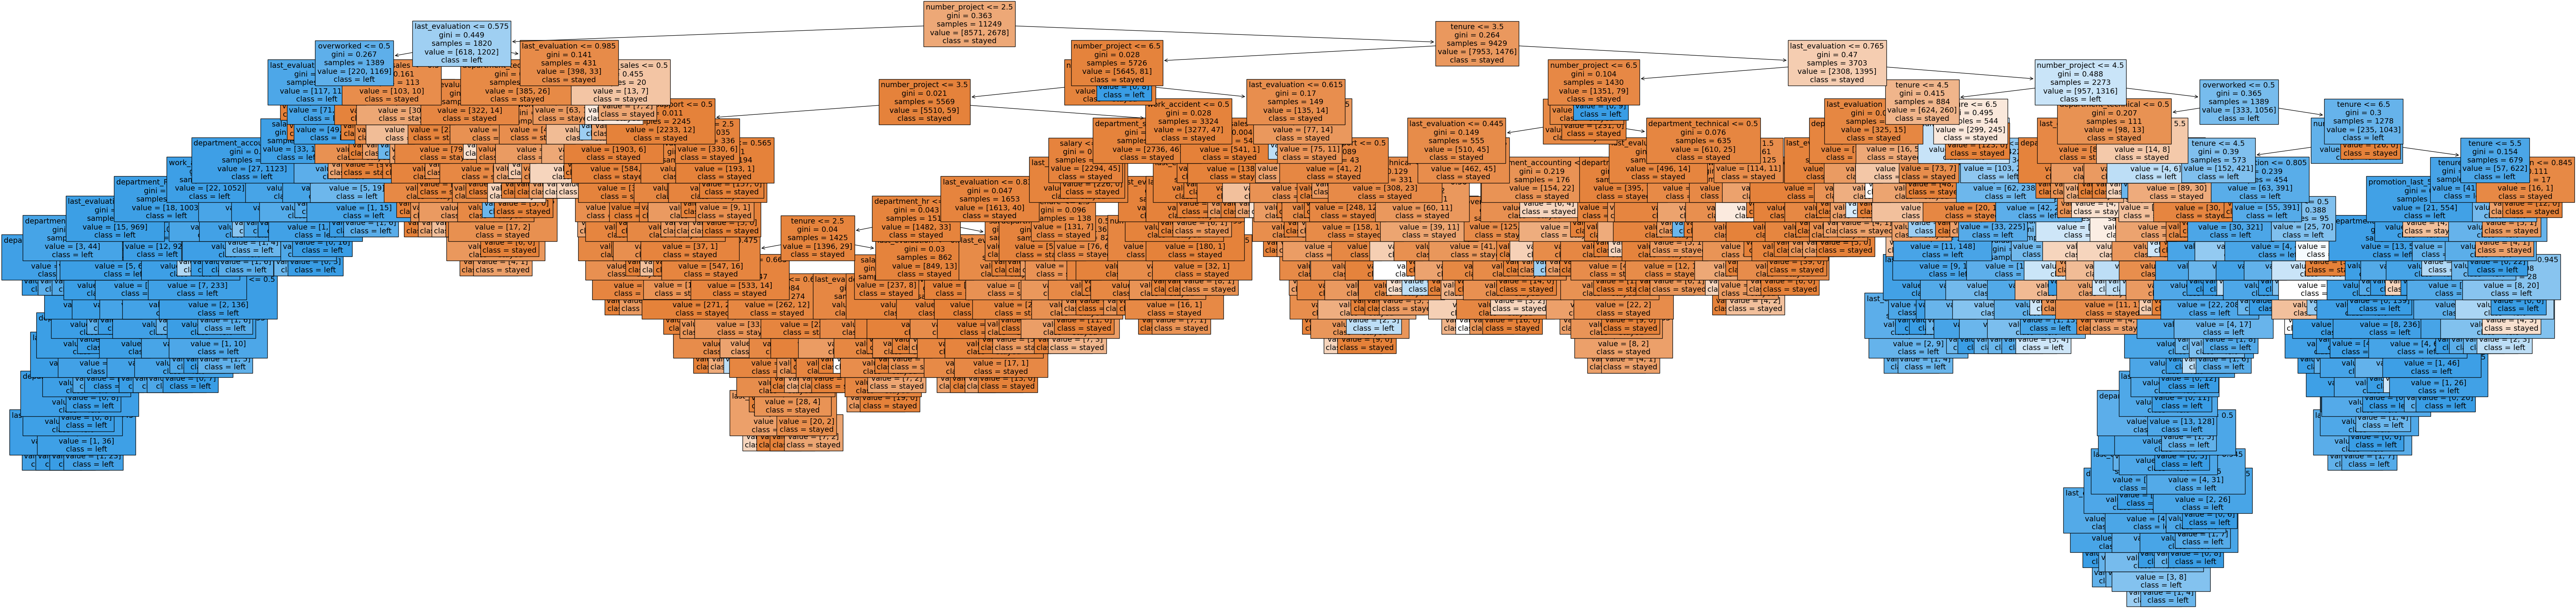

In [43]:
# Plot the tree
plt.figure(figsize=(85,20))
plot_tree(tree2.best_estimator_, max_depth= None, fontsize= 14, feature_names= X.columns, class_names= {0:'stayed', 1:'left'}, filled= True)
plt.show()

In [44]:
# Decision tree feature importance
tree2_importance= pd.DataFrame(tree2.best_estimator_.feature_importances_, columns= ['gini_importance'], index= X.columns)
tree2_importance= tree2_importance.sort_values(by= 'gini_importance', ascending= False)
tree2_importance= tree2_importance[tree2_importance['gini_importance'] != 0]
tree2_importance

,gini_importance
number_project,0.313316
last_evaluation,0.312700
tenure,0.266540
overworked,0.082346
salary,0.010098
department_technical,0.003992
department_sales,0.002792
work_accident,0.001986
department_support,0.001362
promotion_last_5years,0.001345


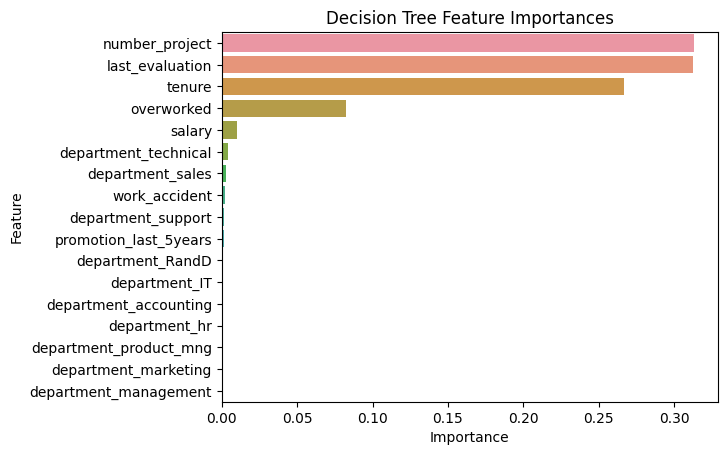

In [45]:
# Barplot to visualize gini importance
sns.barplot(data= tree2_importance, x= 'gini_importance', y= tree2_importance.index, orient= 'h')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Decision Tree Feature Importances')
plt.show()

**Feature Importance Barplot**

The features that are most helpful in this decision tree model fo predicting employee churn are 'number_project', 'last_evaluation', 'tenure' and 'overworked'.

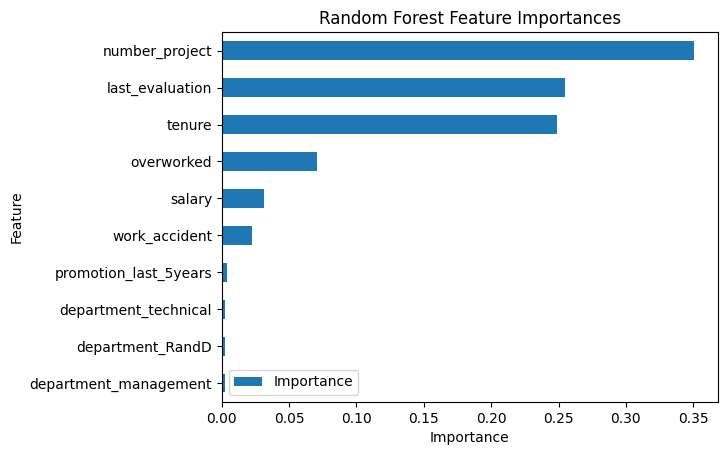

In [46]:
# Random Forest Feature Importances
feat_impt= rf2.best_estimator_.feature_importances_

# Top 10 features
ind= np.argpartition(rf2.best_estimator_.feature_importances_, -10)[-10:]
feat= X.columns[ind]
feat_impt= feat_impt[ind]

y_df= pd.DataFrame({'Feature': feat, 'Importance': feat_impt})
y_sort_df= y_df.sort_values('Importance')
fig= plt.figure()
ax1= fig.add_subplot(111)

y_sort_df.plot(kind= 'barh', ax= ax1, x= 'Feature', y= 'Importance')

ax1.set_ylabel('Feature')
ax1.set_xlabel('Importance')
ax1.set_title('Random Forest Feature Importances', fontsize=12)


plt.show()

**Random Forest Feature Importances**

The features that are most helpful in this random forest model for predicting employee churn are 'number_project', 'last_evaluation', 'tenure' and 'overworked'.

**Evaluation Metrics for the models**

1. **AUC**- the area under the ROC curve. It's also considered the probability that the model ranks a random positive example more highly than a random negative example.

2. **Precision**- measures the proportion of data points predicted as True that are actually True, in other words, the proportion of positive predictions that are true positives.

3. **Recall**- measures the proportion of data points that are predicted as True, out of all the data points that are actually True. In other words, it measures the proportion of positives that are correctly classified.

4. **Accuracy**- measures the proportion of data points that are correctly classified.

5. **F1-score**- an aggregation of precision and recall.

**Summary of Model Results**

1. **Logistic Regression**

The logistic regression model acheived a precision of 81%, recall of 82%, F1 score of 81% (all weighted averages) and an accuracy score of 82% on the test set.

2. **Decision Tree**

After implementing feature engineering, the decision tree model achevied a AUC of 97%, precision of 91%, recall of 89%, accuracy of 95% and an F1 score of 90%.

3. **Random Forest**

After implementing feature engineering, the random forest model acheived a precision of 98%, recall of 93%, an F1 score of 96%, an accuracy of 98% and an AUC of 99%.

**Champion Model**

Among the models evaluated, the Random Forest emerges as the champion model due to its superior performance across multiple metrics. With precision, recall, and F1 score exceeding 90%, an accuracy rate of 98%, and an impressive AUC of 99%, the Random Forest model demonstrates robustness and reliability in predicting employee churn. Its ability to maintain high precision while effectively capturing true positives and true negatives makes it the preferred choice for practical deployment in real-world scenarios.

**Conclusion and Recommendations**

Based on the insights derived from the models and the feature importances, it appears that employees at the Salifort Motors are experiencing a culture of burnout and excessive workloads, which is contributing to employee dissatisfaction and potential turnover. To address this issue and improve employee retention, the following recommendations could be presented to stakeholders:

1. Implement a policy to limit the number of concurrent projects assigned to employees, ensuring a manageable workload and preventing overcommitment.

2. Conduct a thorough review of the company's promotion and career advancement policies, specifically investigating the reasons for dissatisfaction among employees with four years of tenure. Consider implementing a more structured promotion process or providing additional incentives to retain experienced employees.

3. Evaluate the company's compensation and rewards structure, particularly regarding overtime and extended work hours. Either establish appropriate incentives or rewards for employees who work beyond regular hours or recalibrate the workload expectations to align with standard working hours.

4. Ensure transparent communication of the company's overtime pay policies and work-life balance expectations. If these policies are not clearly defined or communicated, take immediate steps to disseminate this information to all employees.

5. Foster open communication channels by facilitating company-wide and team-level discussions. This will allow for a better understanding of the prevailing work culture, identifying areas of concern, and gathering feedback from employees to implement targeted improvements.

6. Reevaluate the criteria for performance evaluations and rewards. Decouple high evaluation scores from the sole metric of excessive work hours, and instead, consider a proportionate scale that recognizes and rewards employees based on their overall contributions and effort, rather than solely on the number of hours worked.

By implementing these recommendations, the company can address the underlying issues of excessive workloads, promote a healthier work-life balance, and foster a more supportive and inclusive work environment, ultimately contributing to improved employee satisfaction and retention.
